## NB 10.7 mistergroot

In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import toyplot

/home/nicolas/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [33]:
# fix a random seed
np.random.seed(66666)

# generating data for 190 years with high rates of bearded individuals for 100 years, low rates for 30 years after, 
# and a high rate for the final 60 years. This should theoretically give us two switchpoints
data = pd.DataFrame({
    "year": np.arange(1825, 2015),
    "bearded_individuals": np.concatenate([
        np.random.poisson(10.0, 100),
        np.random.poisson(3.5, 30),
        np.random.poisson(8.0, 60),
    ])
})

# introduce some random NaN values (pymc3 will handle these). Not necessary for this practice notebook but I left it in
missing = np.random.randint(0, data.shape[0], 3)
data.loc[missing, "bearded_individuals"] = np.nan

#### Scatterplot of the simulated data

In [24]:
toyplot.scatterplot(
    data.year,
    data.bearded_individuals, 
    width=450, 
    height=300,
    size=8, 
    opacity=0.5,
    xlabel="year", 
    ylabel="N Bearded Individuals on the Street",
);

1850 1900 1950 2000 year 0 5 10 15 20 N Bearded Individuals on the Street

#### Model of the data with a test value centered around the approximate first switchpoint

In [25]:
with pm.Model() as beard_model:

    # sample switchpoint from within the bounds of our data timescale
    switchpoint = pm.DiscreteUniform(
        'switchpoint',
        lower=data.year.min(), 
        upper=data.year.max(), 
        testval=1920)

    # Priors for pre- and post-switch rates for number of disasters
    early_rate = pm.Exponential('early_rate', 1.)
    late_rate = pm.Exponential('late_rate', 1.)

    # Allocate appropriate Poisson rates to years before and after current
    rate = pm.math.switch(switchpoint >= data.year, early_rate, late_rate)

    bearded_individuals = pm.Poisson('bearded individuals', rate, observed=data.bearded_individuals)

#### Second model of the data with a test value centered around the approximate second switchpoint

In [26]:
with pm.Model() as beard_model2:

    # sample switchpoint from within the bounds of our data timescale
    switchpoint = pm.DiscreteUniform(
        'switchpoint',
        lower=data.year.min(), 
        upper=data.year.max(), 
        testval=1950)

    # Priors for pre- and post-switch rates for number of disasters
    early_rate = pm.Exponential('early_rate', 1.)
    late_rate = pm.Exponential('late_rate', 1.)

    # Allocate appropriate Poisson rates to years before and after current
    rate = pm.math.switch(switchpoint >= data.year, early_rate, late_rate)

    bearded_individuals = pm.Poisson('bearded individuals', rate, observed=data.bearded_individuals)

In [27]:
with beard_model:
    trace = pm.sample(50000)

/home/nicolas/miniconda3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [bearded individuals_missing]
>>Metropolis: [switchpoint]
>NUTS: [late_rate_log__, early_rate_log__]
 93%|█████████▎| 46885/50500 [01:10<00:05, 660.79it/s]/home/nicolas/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/nicolas/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/nicolas/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
100%|█████████▉| 50462/50500 [01:14<00

In [28]:
with beard_model2:
    trace2 = pm.sample(50000)

/home/nicolas/miniconda3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [bearded individuals_missing]
>>Metropolis: [switchpoint]
>NUTS: [late_rate_log__, early_rate_log__]
 92%|█████████▏| 46482/50500 [01:06<00:05, 704.03it/s]/home/nicolas/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
 93%|█████████▎| 47056/50500 [01:06<00:04, 704.87it/s]/home/nicolas/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
 93%|█████████▎| 47136/50500 [01:06<00:04, 704.85it/s]/home/nicolas/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumer

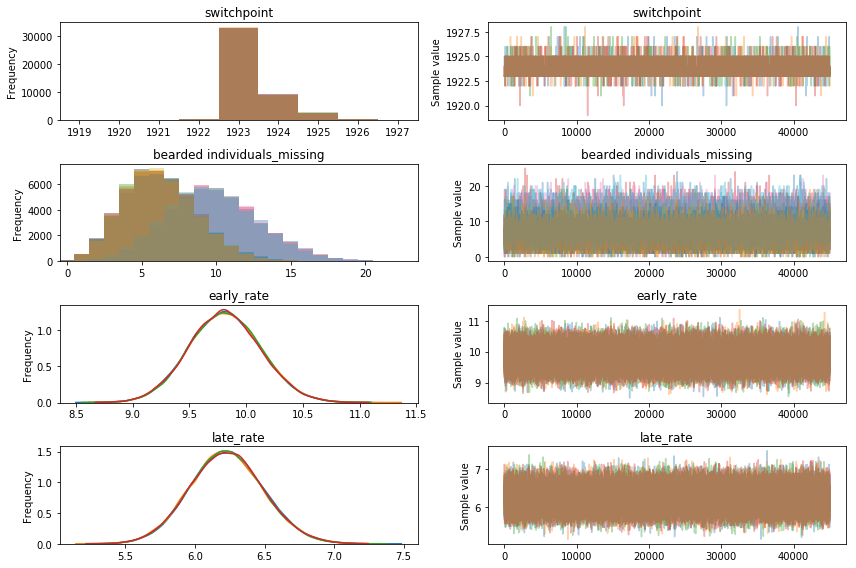

In [29]:
pm.traceplot(trace[5000:]);

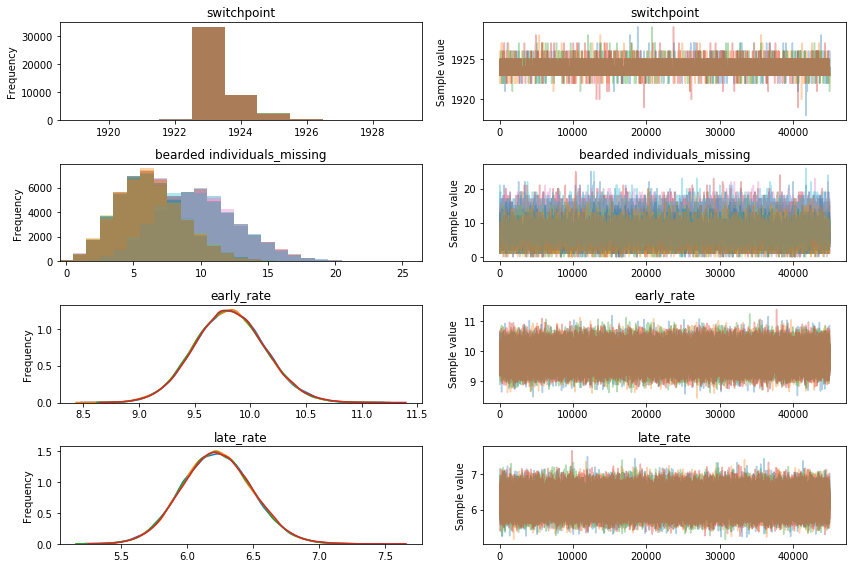

In [30]:
pm.traceplot(trace2[5000:]);

In [31]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
switchpoint,1923.329025,0.630323,0.003740,1923.000000,1925.000000,25145.0,1.000004
bearded individuals_missing__0,9.784650,3.156190,0.027522,3.000000,15.000000,13824.0,1.000460
bearded individuals_missing__1,6.242190,2.524938,0.019277,2.000000,11.000000,19056.0,1.000060
bearded individuals_missing__2,6.223915,2.489061,0.019035,2.000000,11.000000,17990.0,1.000001
early_rate,9.811860,0.314668,0.000752,9.190900,10.422462,155753.0,0.999993
late_rate,6.227331,0.263525,0.000719,5.712209,6.745288,144034.0,1.000002


In [32]:
pm.summary(trace2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
switchpoint,1923.324210,0.628115,0.003872,1923.000000,1925.000000,23550.0,1.000005
bearded individuals_missing__0,9.814135,3.133126,0.026882,3.000000,15.000000,13805.0,1.000053
bearded individuals_missing__1,6.235550,2.527494,0.018349,2.000000,11.000000,18948.0,1.000033
bearded individuals_missing__2,6.232365,2.510126,0.017333,2.000000,11.000000,19642.0,1.000004
early_rate,9.811651,0.315050,0.000783,9.202830,10.437134,161499.0,0.999993
late_rate,6.227170,0.264608,0.000613,5.714311,6.748292,159375.0,0.999999


## Are your parameters within the 95% HPD Interval?

#### Yes. The first switchpoint was estimated to be around 1923 which makes sense given that I created a period of decreased rates of bearded individuals that began at 1925 so the switchpoint would have to begin slightly prior to this. I will expand on the issues with the second switchpoint in the third question.


## Do you think you ran the MCMC sampler long enough?

#### Yes. I ran the MCMC for 50000 steps for each approximate switchpoint and disposed of the first 10% (5000) of the steps before running the trace.

## Do you think anything went wrong? If so, what did you try to troubleshoot the problem? Did you seek help or answers?

#### I think something went wrong with the second switchpoint. Even though I gave an approximate `testval` of `1950` for the second model/switchpoint, it did not find a second switchpoint which I tried to implement with my 3-stage generated data. I think this is because the theoretical second switchpoint was after a short period of low values and that period wasn't enough to be distinguished from randomness in the 3rd phase of rates. If I made the 2nd period longer, it might have been picked up by the model/trace and there would be a second switchpoint.  I tried to fix this by creating a lengthened second stage of lower rates and a shorter third stage of high rates but `model2` kept freezing when I ran it with the new parameters so I couldn't see if it made a difference in the trace/traceplot nor the summary. I couldn't find anything on Google but I'm pretty sure the issues were just due to the inability of the computer to distinguish the second and third stages. I believe this because it writes that the "late rate" is ~6.23 with a 95% confidence interval of (5.71,6.75) which indicates to me that it just interpreted the second and third stages as one unit with no inflection.

